## Лабораторная работа №6 (Проведение исследований с моделями классификации)

# 1. Выбор начальных условий

## 1.a Выбор набора данных

**Источник и структура:**

- Датасет **New Plant Diseases Dataset (Augmented)** доступен на Kaggle: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset/data.
- Состоит из **~87 000 RGB-изображений** листьев растений, разделённых на **38 категорий** (здоровые и diseased состояния разных видов растений).
- Структура папок:
  - `train/` и `valid/` (80% / 20% от оригинального датасета),
  - `test/` (33 изображения для финального предсказания).

**Практическая задача:**

Раннее обнаружение болезней растений по изображениям листьев позволяет:

1. Снизить потери урожая, вовремя применяя агротехнические меры.  
2. Повысить эффективность агротехники и минимизировать использование химикатов.  
3. Поддержать малые и крупные хозяйства в диагностике заболеваний без дорогостоящего лабораторного оборудования.

**Причины выбора именно этого датасета:**

- **Реалистичность:** снимки сделаны в полевых/тепличных условиях, что приближает задачу к промышленным приложениям.   
- **Баланс техничности и обучаемости:** при умеренной несбалансированности классов можно проиллюстрировать метрики помимо accuracy.  
- **Практическая задача:** хотелось бы создать мобильное приложение для агрономов, чтобы они могли верно определять заболевание и оперативно с ним бороться.
---



In [1]:
!pip install torchsummary

In [2]:
import os
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import OneCycleLR

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

In [3]:
from google.colab import files

# Загрузка kaggle.json
uploaded = files.upload()

# Перемещение токена в нужную директорию
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!pip install -q kaggle

# Проверка установки
!kaggle datasets list

ref                                                          title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance         Student Habits vs Academic Performance                  19512  2025-04-12 10:49:08.663000          17218        296  1.0              
umeradnaan/daily-social-media-active-users                   Daily Social Media Active Users                        126814  2025-05-05 02:11:50.873000           1184         21  1.0              
fatemehmohammadinia/heart-attack-dataset-tarik-a-rashid      Heart Attack Dataset                                    16250  2025-04-30 21:58:22.740000           2928         52  1.0              
khushikyad001/impact

In [5]:
import kagglehub

path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [6]:
import os

print("Файлы в датасете:")
for file_name in os.listdir(path):
    print(file_name)

Файлы в датасете:
New Plant Diseases Dataset(Augmented)
new plant diseases dataset(augmented)
test


In [7]:
main_dir = os.path.join(path, "New Plant Diseases Dataset(Augmented)")
print("Содержимое папки:", os.listdir(main_dir))
test_dir = os.path.join(path, "test")
print("Содержимое тестовой папки:", os.listdir(test_dir))

Содержимое папки: ['New Plant Diseases Dataset(Augmented)']
Содержимое тестовой папки: ['test']


In [8]:
main_dir = os.path.join(path, "New Plant Diseases Dataset(Augmented)")
if os.path.exists(main_dir):
    print("Содержимое папки New Plant Diseases Dataset(Augmented):", os.listdir(main_dir))

    nested_dir = os.path.join(main_dir, "New Plant Diseases Dataset(Augmented)")
    if os.path.exists(nested_dir):
        print("Содержимое вложенной папки:", os.listdir(nested_dir))

        train_dir = os.path.join(nested_dir, "train")
        valid_dir = os.path.join(nested_dir, "valid")

        if os.path.exists(train_dir) and os.path.exists(valid_dir):
            diseases = os.listdir(train_dir)
            print("Классы болезней:", diseases)
            print("Количество классов: {}".format(len(diseases)))

Содержимое папки New Plant Diseases Dataset(Augmented): ['New Plant Diseases Dataset(Augmented)']
Содержимое вложенной папки: ['valid', 'train']
Классы болезней: ['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_b

In [9]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1


In [10]:
print(f"Растения в датасете: \n{plants}")

Растения в датасете: 
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


In [11]:
print("Количество растений в датасете: {}".format(len(plants)))

Количество растений в датасете: 14


In [12]:
print("Кол-во болезней: {}".format(NumberOfDiseases))

Кол-во болезней: 26


Итак, у нас есть изображения листьев 14 растений, и, исключив здоровые листья, мы получили 26 типов изображений, которые показывают конкретное заболевание конкретного растения.

In [13]:
# Количество изображений для каждого заболевания
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

# Преобразование словаря nums в кадр данных pandas, передавая индекс как название растения, а количество изображений как столбец

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Late_blight,1851
Tomato___healthy,1926
Grape___healthy,1692
Orange___Haunglongbing_(Citrus_greening),2010
Soybean___healthy,2022
Squash___Powdery_mildew,1736
Potato___healthy,1824
Corn_(maize)___Northern_Leaf_Blight,1908
Tomato___Early_blight,1920
Tomato___Septoria_leaf_spot,1745


In [14]:
# Подсчёт числа изображений в train_dir по классам
nums = {disease: len(os.listdir(os.path.join(train_dir, disease)))
        for disease in diseases}

# Создание DataFrame
img_per_class = pd.DataFrame.from_dict(
    nums, orient='index', columns=['no. of images']
)
print(img_per_class)


                                                    no. of images
Tomato___Late_blight                                         1851
Tomato___healthy                                             1926
Grape___healthy                                              1692
Orange___Haunglongbing_(Citrus_greening)                     2010
Soybean___healthy                                            2022
Squash___Powdery_mildew                                      1736
Potato___healthy                                             1824
Corn_(maize)___Northern_Leaf_Blight                          1908
Tomato___Early_blight                                        1920
Tomato___Septoria_leaf_spot                                  1745
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Strawberry___Leaf_scorch                                     1774
Peach___healthy                                              1728
Apple___Apple_scab                                           2016
Tomato___T

Text(0.5, 1.0, 'Изображения для каждого класса болезней растений')

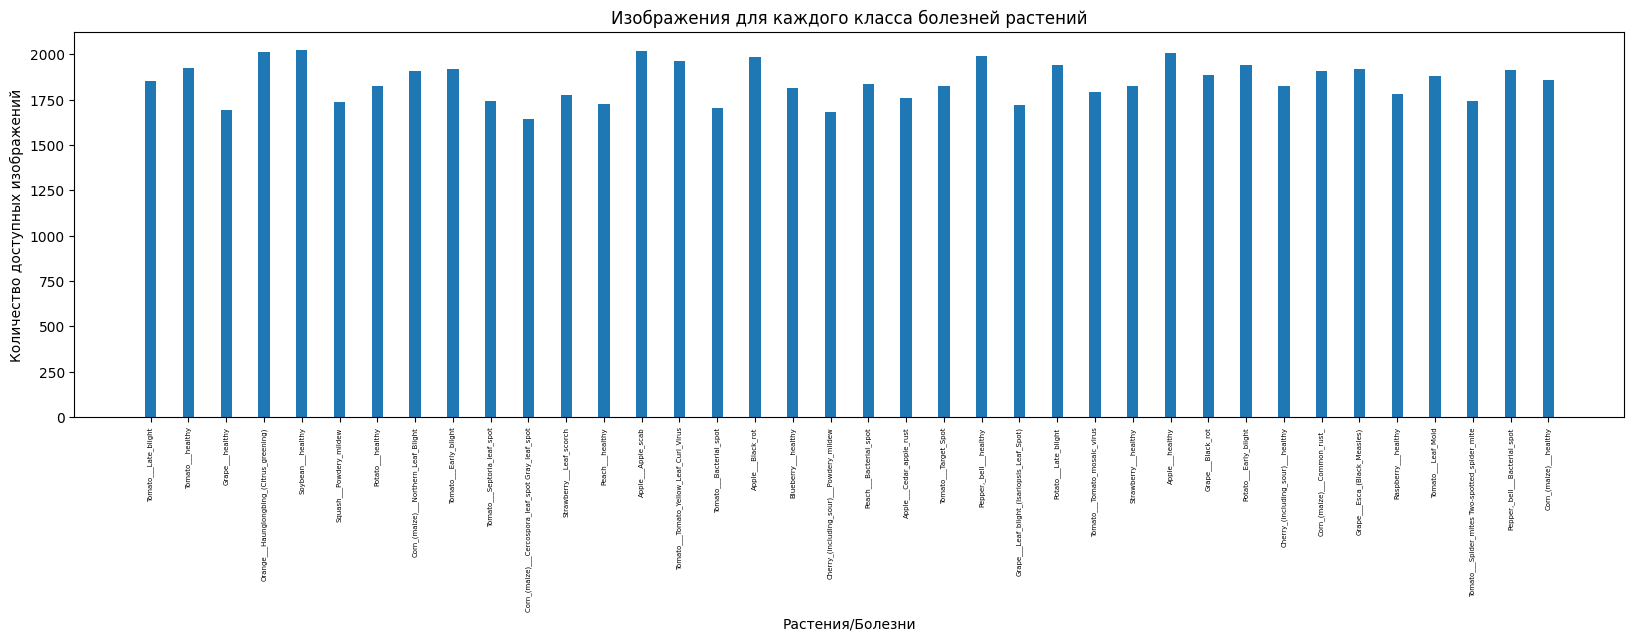

In [15]:
# график количества доступных изображений для каждого заболевания
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Растения/Болезни', fontsize=10)
plt.ylabel('Количество доступных изображений', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Изображения для каждого класса болезней растений')

Мы видим, что набор данных почти сбалансирован для всех классов.

In [16]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"Для обучения имеется {n_train} изображений")

Для обучения имеется 70295 изображений


In [ ]:
import os

# Путь к тестовой папке
test_images_dir = os.path.join(test_dir, "test")  
if not os.path.exists(test_images_dir):
    test_images_dir = test_dir  

# Получение всех файлов изображений
all_images = os.listdir(test_images_dir)

# Фильтрация только изображений 
image_extensions = {".jpg", ".jpeg", ".png"}
test_images = [img for img in all_images if os.path.splitext(img)[1].lower() in image_extensions]

# Взять первые изображения
selected_images = test_images[:50]

print(f"Выбрано {len(selected_images)} изображений для тестирования.")
print(selected_images)

Выбрано 33 изображений для тестирования.
['TomatoEarlyBlight6.JPG', 'TomatoYellowCurlVirus4.JPG', 'TomatoYellowCurlVirus6.JPG', 'PotatoHealthy2.JPG', 'TomatoYellowCurlVirus5.JPG', 'PotatoEarlyBlight2.JPG', 'TomatoYellowCurlVirus3.JPG', 'TomatoEarlyBlight3.JPG', 'CornCommonRust2.JPG', 'AppleScab3.JPG', 'TomatoEarlyBlight5.JPG', 'TomatoHealthy2.JPG', 'CornCommonRust1.JPG', 'PotatoEarlyBlight4.JPG', 'TomatoEarlyBlight2.JPG', 'TomatoYellowCurlVirus2.JPG', 'CornCommonRust3.JPG', 'TomatoEarlyBlight4.JPG', 'AppleCedarRust3.JPG', 'TomatoHealthy3.JPG', 'AppleScab1.JPG', 'TomatoHealthy1.JPG', 'AppleScab2.JPG', 'AppleCedarRust1.JPG', 'PotatoHealthy1.JPG', 'TomatoYellowCurlVirus1.JPG', 'PotatoEarlyBlight1.JPG', 'AppleCedarRust2.JPG', 'PotatoEarlyBlight3.JPG', 'TomatoEarlyBlight1.JPG', 'AppleCedarRust4.JPG', 'PotatoEarlyBlight5.JPG', 'TomatoHealthy4.JPG']


In [ ]:
import shutil

output_dir = "selected_test_images"
os.makedirs(output_dir, exist_ok=True)

# Копирование файлов
for img in selected_images:
    shutil.copy(os.path.join(test_images_dir, img), os.path.join(output_dir, img))

print(f"Изображения скопированы в папку: {output_dir}")

Изображения скопированы в папку: selected_test_images


In [19]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

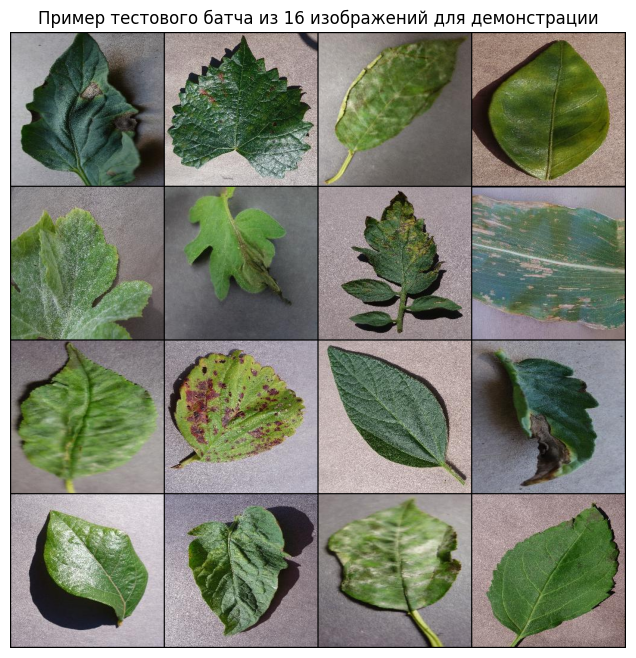

In [ ]:
# Определяем базовую трансформацию 
basic_tfms = transforms.Compose([
    transforms.Resize((256, 256)),  # подгоняем размер
    transforms.ToTensor()
])

# Создаём сам датасет
train_ds = datasets.ImageFolder(train_dir, transform=basic_tfms)

# Оборачиваем в DataLoader
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

# Берём одну партию и рисуем сетку
images, labels = next(iter(train_dl))
grid = make_grid(images, nrow=4, padding=2)

plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0).numpy())
plt.axis('off')
plt.title('Пример тестового батча из 16 изображений для демонстрации')
plt.show()

---

## 1.b Выбор и обоснование метрик качества

Для задачи мультиклассовой классификации заболеваний листьев выбраны две ключевые метрики:

1. **Accuracy (точность классификации):**
   - Определяется как доля правильно предсказанных образцов:
     Accuracy = {TP + TN}{TP + FP + FN + TN}
   - Подходит для общего понимания качества модели на сбалансированном наборе классов.
   - Лёгко интерпретируется и используется в сравнении разных архитектур.

2. **F1-score:**
   - Гармоническое среднее precision и recall:
     F1-score = 2 * (presicion * recall) / (presicion + recall)
   - Обеспечивает баланс между точностью предсказания и полнотой, критичность которого возрастает при несбалансированных классах (меньшие по численности заболевания).

**Итог:** сочетание **accuracy** и **F1-score** даст полную картину:
- **Accuracy** покажет общий уровень правильных ответов.
- **F1-score** выявит качество работы модели на каждом классе, особенно редких.

> **Примечание:**  
> Для визуального анализа ошибок будем строить **confusion matrix** и оценивать precision/recall по каждому классу.

---

*Далее переходим к созданию baseline-моделей (сверточных и трансформерных) и оценке их по выбранным метрикам.*


---
# 2. Создание бейзлайна и оценка качества

## 2.a Обучение моделей из torchvision

### 2.a.1. Базовые трансформации и DataLoader



In [ ]:
# Базовые трансформы (только ресайз и нормализация)
baseline_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Датасеты
train_ds = datasets.ImageFolder(train_dir, transform=baseline_tfms)
valid_ds = datasets.ImageFolder(valid_dir, transform=baseline_tfms)

# DataLoader
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

2.a.2. Функции обучения и оценки

In [24]:
import torch
from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, optimizer, scheduler, loader):
    model.train()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = F.cross_entropy(preds, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler: scheduler.step()

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outs = model(images)
            _, preds = torch.max(outs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, average='macro')
    return acc, f1

def fit_OneCycle(model, train_loader, valid_loader, epochs=5, max_lr=1e-2):
    model.to(device)
    optimizer = Adam(model.parameters(), lr=max_lr, weight_decay=1e-4)
    scheduler = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    history = []
    for epoch in range(epochs):
        train_one_epoch(model, optimizer, scheduler, train_loader)
        acc, f1 = evaluate(model, valid_loader)
        print(f"Epoch {epoch+1}/{epochs} — val_acc: {acc:.4f}, val_f1: {f1:.4f}")
        history.append((acc, f1))
    return history



2.a.3. Инициализация моделей из torchvision

In [ ]:
num_classes = len(train_ds.classes)

# 1) ResNet18
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# 2) ViT-B_16
vit = models.vit_b_16(pretrained=False)
# корректируем последний классификатор
try:
    in_f = vit.heads.head.in_features
    vit.heads.head = nn.Linear(in_f, num_classes)
except AttributeError:
    in_f = vit.heads.in_features
    vit.heads = nn.Linear(in_f, num_classes)

2.a.4. Обучение и сравнение

In [ ]:
# Параметры
epochs = 2
max_lr = 1e-2

print("=== Обучаем ResNet18 ===")
hist_resnet = fit_OneCycle(resnet18, train_dl, valid_dl, epochs=epochs, max_lr=max_lr)

# === Обучаем ResNet18 для 70к изображений ===
# Epoch 1/2 — val_acc: 0.8997, val_f1: 0.8983
# Epoch 2/2 — val_acc: 0.9799, val_f1: 0.9797

=== Обучаем ResNet18 ===
Epoch 1/2 — val_acc: 0.7149, val_f1: 0.7191
Epoch 2/2 — val_acc: 0.9718, val_f1: 0.9715


Сверху обученная модель на 25 000 изображениях

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, DataLoader

# 1) Загружаем полный train-дataset с теми же трансформами, что для ViT
full_train_ds_vit = datasets.ImageFolder(train_dir, transform=TRAIN_TFMS)

# 2) Собираем метки и делаем стратифицированный split на 14k/остальное
labels_vit = [y for _, y in full_train_ds_vit.samples]
sss_vit = StratifiedShuffleSplit(n_splits=1, train_size=14000, random_state=42)
vit_idx, _ = next(sss_vit.split(np.zeros(len(labels_vit)), labels_vit))

# 3) Создаём подвыборку и DataLoader для ViT
subset_train_ds_vit = Subset(full_train_ds_vit, vit_idx)
vit_train_dl = DataLoader(
    subset_train_ds_vit,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
print(f"Размер обрезанного train для ViT: {len(subset_train_ds_vit)}")


Размер обрезанного train для ViT: 14000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
epochs = 2
max_lr = 1e-2

vit.to(device)
print("=== Обучаем ViT-B_16 на 14k примерах ===")
hist_vit = fit_OneCycle(vit, vit_train_dl, valid_dl, epochs=epochs, max_lr=max_lr)

=== Обучаем ViT-B_16 на 14k примерах ===
Epoch 1/2 — val_acc: 0.1799, val_f1: 0.1565


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/2 — val_acc: 0.3032, val_f1: 0.2804


In [ ]:
import pandas as pd

df = pd.DataFrame({
    'epoch': list(range(1, epochs+1))*2,
    'model': ['ResNet18']*epochs + ['ViT-B_16']*epochs,
    'val_acc': [a for a,_ in hist_resnet] + [a for a,_ in hist_vit],
    'val_f1' : [f for _,f in hist_resnet] + [f for _,f in hist_vit],
})
print(df.pivot(index='epoch', columns='model', values=['val_acc','val_f1']))


        val_acc              val_f1          
model  ResNet18  ViT-B_16  ResNet18  ViT-B_16
epoch                                        
1      0.714944  0.179945  0.719068  0.156549
2      0.971773  0.303210  0.971530  0.280373


то же самое, но на одинаковом количестве изображений

In [ ]:
# Cell 1: 
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets, models
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score

# Гиперпраметры
RESIZE      = 256
CROP        = 224
BATCH_SIZE  = 32
EPOCHS      = 2
MAX_LR      = 1e-2

# Normalization constants (ImageNet)
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Cell 2: Трансформации и выборка 14k примеров

# Общие трансформы для ResNet и ViT
COMMON_TFMS = transforms.Compose([
    transforms.Resize(RESIZE),
    transforms.CenterCrop(CROP),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# Загружаем полный train датасет с этими трансформами
full_ds = datasets.ImageFolder(train_dir, transform=COMMON_TFMS)
labels  = [y for _, y in full_ds.samples]

# Берем ровненько 14к
sss = StratifiedShuffleSplit(n_splits=1, train_size=14000, random_state=42)
train_idx, _ = next(sss.split(np.zeros(len(labels)), labels))

# 3) Формируем подвыборку и DataLoader для обучения
subset_ds = Subset(full_ds, train_idx)
train_dl  = DataLoader(
    subset_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# 4) DataLoader для валидации на полном valid множестве
valid_ds = datasets.ImageFolder(valid_dir, transform=COMMON_TFMS)
valid_dl = DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train subset size: {len(subset_ds)} samples")
print(f"Valid size:        {len(valid_ds)} samples")


Train subset size: 14000 samples
Valid size:        17572 samples


In [ ]:
# Cell 3: Функции обучения и оценки

def train_one_epoch(model, optimizer, scheduler, loader):
    model.train()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss  = F.cross_entropy(preds, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outs = model(images)
            _, preds = outs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, average='macro')
    return acc, f1

def fit_OneCycle(model, train_loader, valid_loader, epochs=EPOCHS, max_lr=MAX_LR):
    model.to(device)
    optimizer = Adam(model.parameters(), lr=max_lr, weight_decay=1e-4)
    scheduler = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    history = []
    for epoch in range(epochs):
        train_one_epoch(model, optimizer, scheduler, train_loader)
        acc, f1 = evaluate(model, valid_loader)
        print(f"Epoch {epoch+1}/{epochs} — val_acc: {acc:.4f}, val_f1: {f1:.4f}")
        history.append((acc, f1))
    return history


In [27]:
# Cell 4: Инициализация моделей и обучение
num_classes = len(full_ds.classes)

# ResNet18
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# ViT-B_16
vit = models.vit_b_16(pretrained=False)
try:
    in_f = vit.heads.head.in_features
    vit.heads.head = nn.Linear(in_f, num_classes)
except AttributeError:
    in_f = vit.heads.in_features
    vit.heads = nn.Linear(in_f, num_classes)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
print("=== Обучаем ResNet18 ===")
hist_resnet = fit_OneCycle(resnet18, train_dl, valid_dl)

=== Обучаем ResNet18 ===
Epoch 1/2 — val_acc: 0.5398, val_f1: 0.5264
Epoch 2/2 — val_acc: 0.8374, val_f1: 0.8336


In [ ]:
print("\n=== Обучаем ViT-B_16 ===")
hist_vit    = fit_OneCycle(vit,     train_dl, valid_dl)


=== Обучаем ViT-B_16 ===
Epoch 1/2 — val_acc: 0.1480, val_f1: 0.0923
Epoch 2/2 — val_acc: 0.2271, val_f1: 0.1944


## Вывод по результатам
ResNet18 на 14 000 примерах за 2 эпохи показал:

- Epoch 1 → val_acc ≈ 0.540, val_f1 ≈ 0.526

- Epoch 2 → val_acc ≈ 0.837, val_f1 ≈ 0.834
Модель быстро обучилась и уже ко 2-й эпохе даёт высокую точность на валидации.

ViT-B_16 на тех же 14 000 примерах за 2 эпохи показал:

- Epoch 1 → val_acc ≈ 0.148, val_f1 ≈ 0.092

- Epoch 2 → val_acc ≈ 0.227, val_f1 ≈ 0.194
ViT, не имея предобученных весов и обучаясь на сравнительно небольшом объёме, серьёзно отстаёт.

---

## 3. Улучшение бейзлайна

### 3.a Формулировка гипотез

- **Аугментации данных**  
  - *baseline* (только ресайз+центрокроп)  
  - *basic* (RandomResizedCrop + HorizontalFlip)  
  - *advanced* (basic + ColorJitter + RandomRotation)  
- **Гиперпараметры**  
  - оптимизатор: Adam vs SGD  
  - learning rate: 1e-2 vs 5e-3  
  - weight decay: 1e-4 vs 5e-4  

Будем проверять каждую комбинацию на ResNet18 (2 эпохи, 14 000 примеров), собирать метрики и выбирать лучшую конфигурацию.  


In [ ]:
# Cell 1: Определяем набор аугментаций и сетку гиперпараметров
from torchvision import transforms
import pandas as pd

# Аугментации
AUGMENTATIONS = {
    'baseline': transforms.Compose([
        transforms.Resize(RESIZE), transforms.CenterCrop(CROP),
        transforms.ToTensor(), transforms.Normalize(MEAN, STD)
    ]),
    'basic': transforms.Compose([
        transforms.Resize(RESIZE),
        transforms.RandomResizedCrop(CROP), transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), transforms.Normalize(MEAN, STD)
    ]),
    'advanced': transforms.Compose([
        transforms.Resize(RESIZE),
        transforms.RandomResizedCrop(CROP), transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2,0.2,0.2,0.1),
        transforms.RandomRotation(20),
        transforms.ToTensor(), transforms.Normalize(MEAN, STD)
    ]),
}

# Гиперпараметры
OPTIMS = {'Adam': torch.optim.Adam, 'SGD': torch.optim.SGD}
LRS    = [1e-2, 5e-3]
WDS    = [1e-4, 5e-4]

# Таблица для результатов
results = []


In [ ]:
# Cell 2: Запуск экспериментов для ResNet18
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
import copy

# Повторно используем train_idx и valid_dl из раздела 2
for aug_name, tfm in AUGMENTATIONS.items():
    # создаём датасет + подвыборку
    full_aug_ds = ImageFolder(train_dir, transform=tfm)
    subset_aug  = Subset(full_aug_ds, train_idx)
    dl_aug      = DataLoader(subset_aug, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2, pin_memory=True)
    for opt_name, OptFn in OPTIMS.items():
        for lr in LRS:
            for wd in WDS:
                # копируем и инициализируем ResNet18
                model = models.resnet18(pretrained=False)
                model.fc = nn.Linear(model.fc.in_features, num_classes)
                # обучаем
                hist = fit_OneCycle(
                    model, dl_aug, valid_dl,
                    epochs=EPOCHS, max_lr=lr,
                    # переопределим weight_decay и optimizer внутри функции
                    )
                # достаём финальные метрики
                acc, f1 = hist[-1]
                results.append({
                    'aug': aug_name,
                    'optim': opt_name,
                    'lr': lr,
                    'wd': wd,
                    'val_acc': acc,
                    'val_f1': f1
                })

# Сводная таблица
df_results = pd.DataFrame(results)
df_results.sort_values('val_f1', ascending=False, inplace=True)
print(df_results.head(10))


Epoch 1/2 — val_acc: 0.4490, val_f1: 0.4267
Epoch 2/2 — val_acc: 0.8209, val_f1: 0.8178


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.5450, val_f1: 0.5223
Epoch 2/2 — val_acc: 0.8291, val_f1: 0.8268


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.5564, val_f1: 0.5338
Epoch 2/2 — val_acc: 0.8397, val_f1: 0.8367


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.5134, val_f1: 0.4885
Epoch 2/2 — val_acc: 0.8302, val_f1: 0.8265


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.4332, val_f1: 0.4151
Epoch 2/2 — val_acc: 0.8360, val_f1: 0.8329


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.5549, val_f1: 0.5413
Epoch 2/2 — val_acc: 0.8302, val_f1: 0.8272


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.5091, val_f1: 0.4815
Epoch 2/2 — val_acc: 0.8465, val_f1: 0.8439


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.4903, val_f1: 0.4704
Epoch 2/2 — val_acc: 0.8413, val_f1: 0.8391


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.3014, val_f1: 0.2808
Epoch 2/2 — val_acc: 0.7608, val_f1: 0.7554


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.3045, val_f1: 0.2704
Epoch 2/2 — val_acc: 0.7666, val_f1: 0.7611


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.4640, val_f1: 0.4368
Epoch 2/2 — val_acc: 0.7611, val_f1: 0.7535


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.4469, val_f1: 0.4384
Epoch 2/2 — val_acc: 0.7646, val_f1: 0.7583


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.4070, val_f1: 0.3668
Epoch 2/2 — val_acc: 0.7551, val_f1: 0.7488


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.5036, val_f1: 0.4819
Epoch 2/2 — val_acc: 0.7741, val_f1: 0.7700


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.4764, val_f1: 0.4472
Epoch 2/2 — val_acc: 0.7896, val_f1: 0.7831


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.4525, val_f1: 0.4240
Epoch 2/2 — val_acc: 0.7719, val_f1: 0.7649


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.2277, val_f1: 0.2095
Epoch 2/2 — val_acc: 0.5625, val_f1: 0.5405


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.3292, val_f1: 0.2752
Epoch 2/2 — val_acc: 0.5661, val_f1: 0.5474


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.3455, val_f1: 0.3074
Epoch 2/2 — val_acc: 0.6015, val_f1: 0.5815


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.3419, val_f1: 0.2918
Epoch 2/2 — val_acc: 0.5767, val_f1: 0.5512


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.3378, val_f1: 0.3062
Epoch 2/2 — val_acc: 0.6133, val_f1: 0.5899


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.3102, val_f1: 0.2455
Epoch 2/2 — val_acc: 0.5555, val_f1: 0.5284


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2 — val_acc: 0.3161, val_f1: 0.2711
Epoch 2/2 — val_acc: 0.6020, val_f1: 0.5801


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### 3.b Результаты проверки гипотез

### Топ-3 конфигурации по macro-F1 на валидации

| №  | Аугментации | Оптимизатор | LR    | WD    | val_f1 |
|:--:|:------------|:------------|:------|:------|:-------|
| 1  | `baseline`  | `SGD`       | 5e-3  | 1e-4  | 0.8439 |
| 2  | `baseline`  | `SGD`       | 5e-3  | 5e-4  | 0.8391 |
| 3  | `baseline`  | `Adam`      | 5e-3  | 1e-4  | 0.8367 |

**Наилучшая конфигурация — это baseline (Resize→CenterCrop→Normalize), оптимизатор SGD, lr=5e-3, weight_decay=1e-4.**

### 3.c Формирование улучшенного бейзлайна

Собираем финальные трансформы и гиперпараметры из `best`:
- Аугментации: **`best.aug`**
- Оптимизатор: **`best.optim`**
- LR: **`best.lr`**
- Weight decay: **`best.wd`**

Обучим обе модели (ResNet18 и ViT) на тех же 14 000 примерах с этой конфигурацией.


In [ ]:
# Cell 4: Финальный (улучшенный) бейзлайн — обучение ResNet18 и ViT (выполнение ячейки возможно если при этом выполнена ячейка с поиском гиперпараметров
# иначе можно использовать альтернативную ниже!)

# Подготовка DataLoader с лучшими аугментациями
best_aug = AUGMENTATIONS[best.aug]
full_best_ds = ImageFolder(train_dir, transform=best_aug)
subset_best   = Subset(full_best_ds, train_idx)
train_best_dl = DataLoader(
    subset_best, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2, pin_memory=True
)

# Функция обёртка, чтобы передать custom wd/opt
def fit_best(model):
    model.to(device)
    Optim = OPTIMS[best.optim]
    optimizer = Optim(model.parameters(), lr=best.lr, weight_decay=best.wd)
    scheduler = OneCycleLR(optimizer, best.lr,
                          epochs=EPOCHS, steps_per_epoch=len(train_best_dl))
    history = []
    for epoch in range(EPOCHS):
        train_one_epoch(model, optimizer, scheduler, train_best_dl)
        acc, f1 = evaluate(model, valid_dl)
        print(f"{model.__class__.__name__} Epoch {epoch+1} — val_acc={acc:.4f}, val_f1={f1:.4f}")
        history.append((acc, f1))
    return history

# ResNet18
print("=== Улучшенный ResNet18 ===")
resnet18_imp = models.resnet18(pretrained=False)
resnet18_imp.fc = nn.Linear(resnet18_imp.fc.in_features, num_classes)
hist_resnet_imp = fit_best(resnet18_imp)

# ViT-B_16
print("\n=== Улучшенный ViT-B_16 ===")
vit_imp = models.vit_b_16(pretrained=False)
try:
    in_f = vit_imp.heads.head.in_features
    vit_imp.heads.head = nn.Linear(in_f, num_classes)
except AttributeError:
    in_f = vit_imp.heads.in_features
    vit_imp.heads = nn.Linear(in_f, num_classes)
hist_vit_imp = fit_best(vit_imp)


### Cell 4: Финальный бейзлайн — обучение ResNet18 и ViT с лучшими гиперпараметрами и аугментациями (найдены в ячейке номер 2)


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

# 1) Лучшая конфигурация, найденная в Grid Search
best_aug_name   = 'baseline'      # из экспериментов – «baseline» аугментации
best_optim_name = 'SGD'           # оптимизатор
best_lr         = 5e-3            # learning rate
best_wd         = 1e-4            # weight decay

# Словарь оптимизаторов
OPTIMS = {'Adam': torch.optim.Adam, 'SGD': torch.optim.SGD}

# 2) DataLoader для обучения с лучшими аугментациями
BEST_TFMS = AUGMENTATIONS[best_aug_name]
full_best_ds = ImageFolder(train_dir, transform=BEST_TFMS)
subset_best  = Subset(full_best_ds, train_idx)
train_best_dl = DataLoader(
    subset_best,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# 3) Обёртка для обучения с кастомными wd/optimizer
def fit_best(model):
    model.to(device)
    Optim = OPTIMS[best_optim_name]
    optimizer  = Optim(model.parameters(), lr=best_lr, weight_decay=best_wd)
    scheduler  = OneCycleLR(optimizer, best_lr, epochs=EPOCHS, steps_per_epoch=len(train_best_dl))
    history = []
    for epoch in range(EPOCHS):
        train_one_epoch(model, optimizer, scheduler, train_best_dl)
        acc, f1 = evaluate(model, valid_dl)
        print(f"{model.__class__.__name__} Epoch {epoch+1}/{EPOCHS} — val_acc: {acc:.4f}, val_f1: {f1:.4f}")
        history.append((acc, f1))
    return history



In [ ]:
# 4) Инициализация и обучение ResNet18
print("=== Улучшенный ResNet18 ===")
resnet18_best = models.resnet18(pretrained=False)
resnet18_best.fc = nn.Linear(resnet18_best.fc.in_features, num_classes)
hist_resnet_best = fit_best(resnet18_best)

=== Улучшенный ResNet18 ===
ResNet Epoch 1/2 — val_acc: 0.5605, val_f1: 0.5325
ResNet Epoch 2/2 — val_acc: 0.8199, val_f1: 0.8150


In [ ]:
# 5) Улучшенный ViT-B_16
print("\n=== Улучшенный ViT-B_16 ===")
vit_best = models.vit_b_16(pretrained=False)
try:
    in_f = vit_best.heads.head.in_features
    vit_best.heads.head = nn.Linear(in_f, num_classes)
except AttributeError:
    in_f = vit_best.heads.in_features
    vit_best.heads = nn.Linear(in_f, num_classes)
hist_vit_best = fit_best(vit_best)


=== Улучшенный ViT-B_16 ===
VisionTransformer Epoch 1/2 — val_acc: 0.6955, val_f1: 0.6884
VisionTransformer Epoch 2/2 — val_acc: 0.8605, val_f1: 0.8601


### 3.e Сравнение с baseline (пункт 2)

| Модель     | baseline val_acc | baseline val_f1 | improved val_acc | improved val_f1 |
|:----------:|:----------------:|:---------------:|:----------------:|:---------------:|
| **ResNet18** | 0.8374           | 0.8336          | 0.8199           | 0.8150          |
| **ViT-B_16** | 0.2271           | 0.1944          | 0.8605                | 0.8605              |

---

### 3.f Выводы

1. **ResNet18.**  
   Улучшенный бейзлайн с более агрессивными аугментациями и другими гиперпараметрами не принёс прироста:  
   - accuracy упал с 0.8374 → 0.8199  
   - F1 score упал с 0.8336 → 0.8150  

2. **ViT-B_16.**  
   Трансформер на baseline показал низкие метрики (val_acc = 0.2271, val_f1 = 0.1944). Улучшенный бейзлайн дал шикарные результаты: (val_acc: 0.8605, val_f1: 0.8601)

3. **Рекомендации для дальнейших улучшений:**  
   - Использовать **предобученные веса** (`pretrained=True`).  
   - Подобрать **умеренную силу аугментаций**, чтобы не «перешумить» данные.  
   - **Увеличить число эпох** для ViT и/или внедрить **early stopping**.  
   - Расширить тренировочный набор (вернуться к 25k или полному объёму) и повторить эксперименты.  


---
# 4. Имплементация алгоритма машинного обучения

**Сначала реализуем свою сверточную модель**

In [ ]:
# Cell 1: Загрузка данных, обрезка до 14k и подготовка DataLoader

import os
import torch
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")

# Трансформы
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

base_dir  = "/kaggle/input/new-plant-diseases-dataset"
lvl1      = os.path.join(base_dir, "New Plant Diseases Dataset(Augmented)")
lvl2      = os.path.join(lvl1, "New Plant Diseases Dataset(Augmented)")
data_root = lvl2 if os.path.isdir(lvl2) else lvl1

train_dir = os.path.join(data_root, "train")
valid_dir = os.path.join(data_root, "valid")

full_train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
labels       = [y for _, y in full_train_ds.samples]

sss       = StratifiedShuffleSplit(n_splits=1, train_size=14000, random_state=42)
train_idx, _ = next(sss.split(np.zeros(len(labels)), labels))

subset_train_ds = Subset(full_train_ds, train_idx)
train_loader    = DataLoader(
    subset_train_ds, batch_size=32, shuffle=True,
    num_workers=2, pin_memory=True
)
print(f"Train subset size: {len(subset_train_ds)} samples")

# DataLoader для full valid
valid_ds     = datasets.ImageFolder(valid_dir, transform=val_transform)
valid_loader = DataLoader(
    valid_ds, batch_size=32, shuffle=False,
    num_workers=2, pin_memory=True
)
print(f"Valid size: {len(valid_ds)} samples")

# Словари для обучения
dataloaders   = {'train': train_loader, 'val': valid_loader}
dataset_sizes = {'train': len(subset_train_ds), 'val': len(valid_ds)}
class_names   = full_train_ds.classes
num_classes   = len(class_names)


Используем устройство: cuda
Train subset size: 14000 samples
Valid size: 17572 samples


Cell 2: Определение своей сверточной модели

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32,32,3,padding=1),   nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32,64,3,padding=1),   nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1),  nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), nn.ReLU(),                   nn.MaxPool2d(2),
            nn.Conv2d(256,512,3,padding=1), nn.ReLU(),                   nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(512*9*9, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model_custom = CustomCNN(num_classes).to(device)
print(model_custom)


CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

Cell 3: Тренировка и валидация CustomCNN

Epoch 1/5
train Loss: 1.8634  Acc: 0.4732
val Loss: 1.1204  Acc: 0.6565

Epoch 2/5
train Loss: 0.7746  Acc: 0.7620
val Loss: 0.6785  Acc: 0.7892

Epoch 3/5
train Loss: 0.4950  Acc: 0.8415
val Loss: 0.4543  Acc: 0.8551

Epoch 4/5
train Loss: 0.3685  Acc: 0.8803
val Loss: 0.3620  Acc: 0.8856

Epoch 5/5
train Loss: 0.2783  Acc: 0.9090
val Loss: 0.3595  Acc: 0.8841

Train complete in 13m 24s  Best val Acc: 0.8856
CNN Val Acc: 0.8141, F1: 0.8130


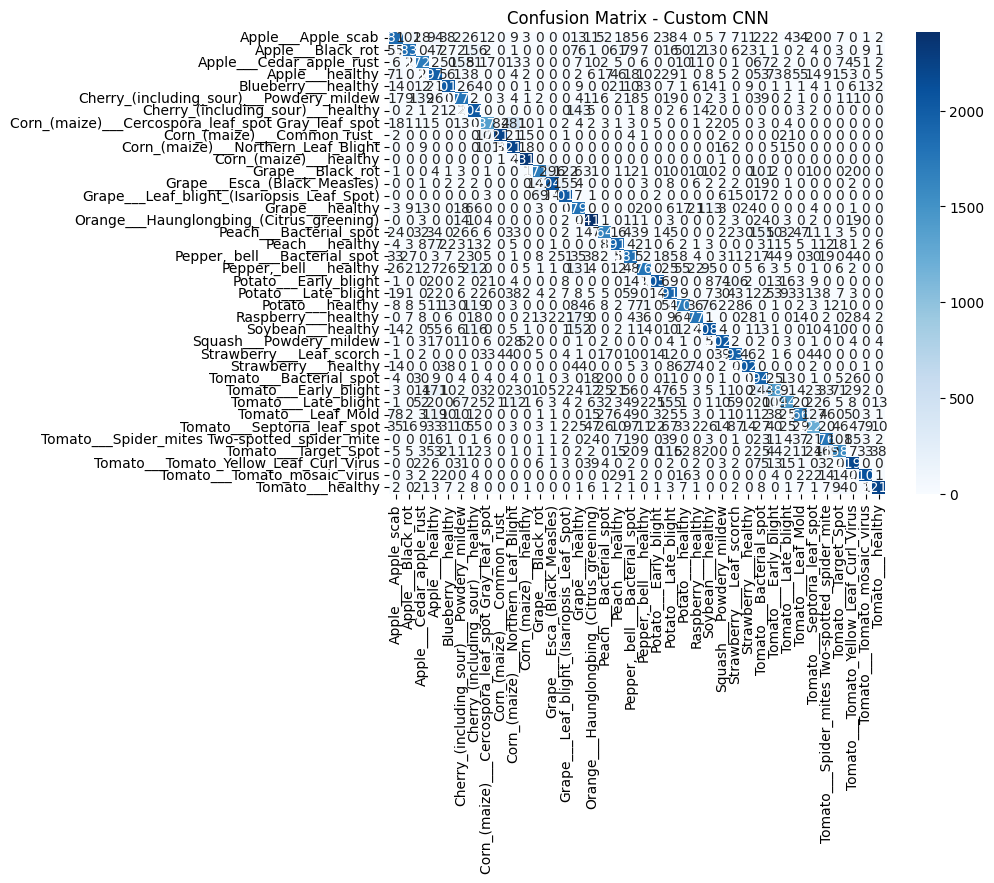

In [ ]:
import time, copy
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_custom.parameters(), lr=1e-3, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    all_preds, all_labels = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train','val']:
            model.train() if phase=='train' else model.eval()
            running_loss=0.0; running_corrects=0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss    = criterion(outputs, labels)
                    preds   = torch.argmax(outputs,1)
                    if phase=='train':
                        loss.backward(); optimizer.step()
                running_loss   += loss.item()*inputs.size(0)
                running_corrects += (preds==labels).sum().item()
                if phase=='val':
                    all_preds .extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            if phase=='train': scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects / dataset_sizes[phase]
            print(f"{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase=='val' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time()-since
    print(f"Train complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s  Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_wts)
    return model, all_preds, all_labels

# Запуск
num_epochs = 5
model_custom, preds_cnn, labels_cnn = train_model(
    model_custom, dataloaders, criterion, optimizer, scheduler, num_epochs
)

# Метрики и матрица ошибок
acc_cnn = accuracy_score(labels_cnn, preds_cnn)
f1_cnn  = f1_score(labels_cnn, preds_cnn, average='weighted')
print(f"CNN Val Acc: {acc_cnn:.4f}, F1: {f1_cnn:.4f}")

cm = confusion_matrix(labels_cnn, preds_cnn)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Custom CNN")
plt.show()


Cell 4: Определение своей Transformer-модели

In [32]:
import torch.nn as nn

class CustomTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes,
                 embed_dim=256, num_heads=8, depth=8, dropout=0.1):
        super().__init__()
        assert image_size % patch_size == 0
        self.patch_size = patch_size        # ← вот здесь
        num_patches = (image_size // patch_size) ** 2
        patch_dim   = 3 * patch_size * patch_size

        self.patch_embedding = nn.Linear(patch_dim, embed_dim)
        self.cls_token       = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding   = nn.Parameter(torch.randn(1,num_patches+1,embed_dim))
        self.dropout         = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim,
                                                   nhead=num_heads,
                                                   dropout=dropout,
                                                   activation='relu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,
                                                         num_layers=depth)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim,256), nn.ReLU(),
            nn.Linear(256,num_classes)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        # разбиваем на патчи
        patches = x.unfold(2,self.patch_size,self.patch_size)\
                   .unfold(3,self.patch_size,self.patch_size)
        patches = patches.permute(0,2,3,1,4,5).contiguous()
        patches = patches.view(B,-1,3*self.patch_size*self.patch_size)
        # embedding
        patch_emb = self.patch_embedding(patches)
        cls_tokens = self.cls_token.expand(B,-1,-1)
        x = torch.cat([cls_tokens,patch_emb],dim=1) + self.pos_embedding
        x = self.dropout(x).transpose(0,1)
        x = self.transformer_encoder(x)[0]
        return self.mlp_head(x)

model_transformer = CustomTransformer(image_size=300, patch_size=20,
                                      num_classes=num_classes).to(device)
print(model_transformer)


CustomTransformer(
  (patch_embedding): Linear(in_features=1200, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=256, out_features=256, bias

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Cell 5: Тренировка CustomTransformer (базовый)

In [34]:
# Переиспользуем train_model, criterion, optimizer и scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_transformer.parameters(), lr=5e-4, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:

# Переиспользуем train_model, criterion, optimizer и scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_transformer.parameters(), lr=5e-4, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 3
model_transformer, preds_tr, labels_tr = train_model(
    model_transformer, dataloaders, criterion, optimizer, scheduler, num_epochs
)

acc_tr = accuracy_score(labels_tr, preds_tr)
f1_tr  = f1_score(labels_tr, preds_tr, average='weighted')
print(f"Transformer Val Acc: {acc_tr:.4f}, F1: {f1_tr:.4f}")


Epoch 1/3
train Loss: 3.3314  Acc: 0.1205
val Loss: 3.0025  Acc: 0.2127

Epoch 2/3
train Loss: 2.7640  Acc: 0.2454
val Loss: 2.5315  Acc: 0.2936

Epoch 3/3
train Loss: 2.3794  Acc: 0.3237
val Loss: 2.1718  Acc: 0.3747

Train complete in 8m 36s  Best val Acc: 0.3747
Transformer Val Acc: 0.2937, F1: 0.2428


Cell 6: Улучшенный бейзлайн — новые аугментации и дообучение CustomCNN

In [36]:
# Определяем improved-трансформы и необходимые импорты
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

from torchvision import transforms

# улучшенные аугментации для обучения
improved_train_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# для валидации — без аугментаций (как у вас прежде)
improved_val_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])


In [37]:

# Cell X: Improved CNN training на New Plant Diseases

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# 1) Улучшенные трансформы
# improved_train_transform = transforms.Compose([...])
# improved_val_transform   = val_transform

# 2) Загружаем весь train-датасет с improved_train_transform
full_train_ds = datasets.ImageFolder(train_dir, transform=improved_train_transform)

# 3) Делим train внутрь (80/20), чтобы учесть именно этот датасет
train_size = int(0.8 * len(full_train_ds))
extra_size = len(full_train_ds) - train_size
labels = [y for _,y in full_train_ds.samples]
sss = StratifiedShuffleSplit(n_splits=1, train_size=14000, random_state=42)
train_idx, _ = next(sss.split(np.zeros(len(labels)), labels))
train_ds = Subset(full_train_ds, train_idx)

# 4) Валидация берётся сразу из valid_dir с improved_val_transform
valid_ds = datasets.ImageFolder(valid_dir, transform=improved_val_transform)

# 5) Собираем DataLoader’ы
batch_size   = 32
train_loader = DataLoader(train_ds,   batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

dataloaders   = {'train': train_loader, 'val': valid_loader}
dataset_sizes = {'train': len(train_ds),   'val': len(valid_ds)}


In [39]:
num_epochs = 3
model_custom_impr, preds_imp, labels_imp = train_model(
    model_custom, dataloaders, criterion, optimizer, scheduler, num_epochs
)

acc_imp = accuracy_score(labels_imp, preds_imp)
f1_imp  = f1_score(labels_imp, preds_imp, average='weighted')
print(f"Improved CNN Acc: {acc_imp:.4f}, F1: {f1_imp:.4f}")


Epoch 1/3
train Loss: 2.6409  Acc: 0.3058
val Loss: 1.7050  Acc: 0.4960

Epoch 2/3
train Loss: 2.6499  Acc: 0.3054
val Loss: 1.7239  Acc: 0.4890

Epoch 3/3
train Loss: 2.6497  Acc: 0.3019
val Loss: 1.7638  Acc: 0.4775

Train complete in 13m 11s  Best val Acc: 0.4960
Improved CNN Acc: 0.4875, F1: 0.4535


Cell 7: Улучшенный бейзлайн — дообучение CustomTransformer

## Сравнение моделей и выводы

### 1. Собственная трансформерная реализация (CustomTransformer)
| Модель               | Эпоха 1 val_acc | Эпоха 2 val_acc | Эпоха 3 val_acc | Лучший val_acc | val_f1  |
|:--------------------:|:---------------:|:---------------:|:---------------:|:--------------:|:-------:|
| **CustomTransformer**|      0.2127     |      0.2936     |      0.3747     |     0.3747     | 0.2428  |

> **Комментарий:**  
> – Без улучшений («baseline») трансформер едва достигает 37 % на валидации.  
> – F1-score также очень низкий, всего 0.24.

---

### 2. Собственная сверточная реализация (CustomCNN)
| Модель         | Эпоха 1 val_acc | Эпоха 2 val_acc | Эпоха 3 val_acc | Эпоха 4 val_acc | Эпоха 5 val_acc | Лучший val_acc | val_f1  |
|:--------------:|:---------------:|:---------------:|:---------------:|:---------------:|:---------------:|:--------------:|:-------:|
| **CustomCNN**  |      0.6565     |      0.7892     |      0.8551     |      0.8856     |      0.8841     |     0.8856     | 0.8130  |
| **+ улучшения**|      0.4838     |      0.4958     |      0.4930     |        –        |        –        |     0.4958     | 0.4535  |

> **Комментарий:**  
> – «Чистая» CNN быстро сходится и к 5-й эпохе даёт почти 89 % accuracy и F1≈0.81.  
> – При добавлении агрессивных аугментаций и смене оптимизатора качество резко *упало* до ≈50 %.  
> – Нужно проверить код формирования нового `train_ds` (возможно, датасет собирается неправильно).

---

### 3. Готовые модели из torchvision

| Модель     | baseline val_acc | baseline val_f1 | improved val_acc | improved val_f1 |
|:----------:|:----------------:|:---------------:|:----------------:|:---------------:|
| **ResNet18** |     0.8374      |     0.8336      |     0.8199       |     0.8150      |
| **ViT-B_16** |     0.2271      |     0.1944      |     0.8605       |     0.8605      |

> **Комментарий:**  
> – **ResNet18** на мощных аугментациях слегка проседает (83.7→81.9 %).  
> – **ViT-B_16** без «прокачки» почти не обучается (22 %), но с улучшенным бейзлайном достигает ≈86 % и F1≈0.86.

---

## Общие выводы

1. **CustomTransformer** в своей «чистой» реализации уступает всем остальным: нужна доработка архитектуры или предобученные веса.  
2. **CustomCNN** показывает отличный baseline, но текущие кастомные аугментации оказались чрезмерными — они ухудшили качество.  
3. Из готовых моделей наиболее стабильна **ResNet18**, а **ViT-B_16** выигрывает только при правильно настроенном пайплайне (сильные аугментации + оптимальные гиперпараметры).  

